<a href="https://colab.research.google.com/github/rezu98/colab/blob/main/mae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

# 1. 데이터 불러오기
file_path = "data_7.xlsx"  # ← 실제 엑셀파일 경로에 맞게 수정
df = pd.read_excel(file_path, sheet_name="Sheet1")
df['date'] = pd.to_datetime(df['date'])

# 2. 2013년 이후 데이터 필터
df = df[df['date'] >= '2013-01-01'].copy()

# 3. 아파트가격 YoY 계산 (KEB 지수 4개)
keb_price_vars = ['hp_apt_all_keb', 'hp_apt_metro_keb', 'hp_apt_other_keb', 'hp_apt_seoul_keb']
for col in keb_price_vars:
    df[f'{col}_yoy'] = df[col].pct_change(periods=12) * 100

# 4. 시차설정 (±12개월)
max_lag = 12
lags = list(range(-max_lag, max_lag+1))

# 5. 시차상관관계 계산 (CSI vs 아파트가격 YoY)
corrs_dict_price = {}
for col in keb_price_vars:
    corrs = []
    for h in lags:
        shifted = df[f'{col}_yoy'].shift(-h)
        valid = df[['csi']].copy()
        valid['shifted_price'] = shifted
        valid = valid.dropna()
        corr = valid['csi'].corr(valid['shifted_price'])
        corrs.append(corr)
    corrs_dict_price[col] = corrs

# 결과 dataframe으로 변환
corrs_df_price = pd.DataFrame(corrs_dict_price, index=lags).reset_index().rename(columns={'index':'lag'})

# 6. 시차상관관계 계산 (CSI vs lev_hd)
corrs_lev_hd = []
for h in lags:
    shifted = df['lev_hd'].shift(-h)
    valid = df[['csi']].copy()
    valid['shifted_lev_hd'] = shifted
    valid = valid.dropna()
    corr = valid['csi'].corr(valid['shifted_lev_hd'])
    corrs_lev_hd.append(corr)

corrs_df_lev_hd = pd.DataFrame({'lag': lags, 'corr': corrs_lev_hd})

# 7. 엑셀로 export
with pd.ExcelWriter("shift_correlation_csi_export.xlsx") as writer:
    corrs_df_price.to_excel(writer, sheet_name="CSI_vs_HousePrice_YoY", index=False)
    corrs_df_lev_hd.to_excel(writer, sheet_name="CSI_vs_LevHD", index=False)


In [ ]:
# @title Text 분석

In [ ]:
##### 1. 폰트 설치 및 패키지 불러오기

import sys
# Google Colab 환경에서 실행 중인지 확인
if 'google.colab' in sys.modules:
    # debconf를 Noninteractive 모드로 설정
    !echo 'debconf debconf/frontend select Noninteractive' | \
    debconf-set-selections

    # fonts-nanum 패키지를 설치
    !sudo apt-get -qq -y install fonts-nanum

    # Matplotlib의 폰트 매니저 가져오기
    import matplotlib.font_manager as fm

    # 나눔 폰트의 시스템 경로 찾기
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])

    # 찾은 각 나눔 폰트를 Matplotlib 폰트 매니저에 추가
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

plt.rc('font', family='NanumBarunGothic', size=11) #사용 방법2
print(plt.rcParams['font.family'], plt.rcParams['font.size'])   # 폰트확인

['NanumBarunGothic'] 11.0


In [1]:
### 1. Word Cloud

# 패키지 불러오기
import pandas as pd
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import re

import networkx as nx
from itertools import combinations
from pyvis.network import Network
!pip install pyvis==0.2.1

ModuleNotFoundError: No module named 'pyvis'

In [2]:
##### 2. 데이터 불러오기


# 1️⃣ 엑셀파일 불러오기
df_news = pd.read_excel("아파트.xlsx")

font_path = 'NanumGothic.ttf'

# 2️⃣ keyword_list 만들기 (원하는 trait 열 → 쉼표 split)
df_news['keyword_list'] = df_news['특성추출(가중치순 상위 50개)'].apply(lambda x: str(x).split(','))
# df_news['keyword_list'] = df_news['키워드'].apply(lambda x: str(x).split(','))

# 3️⃣ 일자 변환 (일자 열: yyyymmdd 텍스트 숫자 → datetime 변환)
df_news['date'] = pd.to_datetime(df_news['일자'], format='%Y%m%d')
df_news['year_month'] = df_news['date'].dt.to_period('M').astype(str)

In [47]:
##### 3. 불용어 등 정의


# 4️⃣ 커스텀 불용어 정의
my_stopwords = ['지난달', '규모', '전망', '단지', '구역', '주택', '만큼',
                '관계자', '한국부동산원', '연구원', '1억', '1만', '부동산', '전주', '현대건설', '전용면적', '위원회', '직방', '전문가', 'a씨', '자치구', '삼성물산', '가능성', '상승률', '건설사', '래미안', '국토부', '경찰', '혐의', 'b씨', '재판부', '피해자',
                '교통부', '운용사', '보고서', '한국', '온라인', '경쟁력', '대한민국', '사업장', '피고인', '힐스테이트', '입주민', '당첨자', '주차장', '주민들','조사', '범행', '건축물',
                '용의자', '남성', '대우건설']

custom_stopwords = set(STOPWORDS)
custom_stopwords.update(my_stopwords)

# 5️⃣ 가중치 사전 정의
custom_weights = {
    '민주당': 1.0,
    '금리': 1.0,
    '미분양': 1.0,
    '정부': 1.0,
    '유동성' : 5.0,
    '성동구' : 1.5,
    '계약금' : 0.2,
    '미국' : 0.5,
    '입주자' : 0.5,
}

# 6️⃣ 단어 치환 사전 정의 (비슷한 단어 통합)
replace_dict = {
    '서울시': '서울',
    '경기도': '경기',
    '토허': '토지거래허가구역',
    '토허제': '토지거래허가구역',
    '토허구역': '토지거래허가구역',
    '한은' : '한국은행',
    '더불어민주당' : '민주당',
    '세종시' : '세종',
    '용인시' : '용인'
    # 원하면 여기에 계속 추가
}

In [48]:
##### 4. Word Cloud

# 6️⃣ 전체 키워드 풀 생성 + 숫자 필터링 + stopwords 필터링
all_keywords = []
for lst in df_news['keyword_list']:
    for kw in lst:
        kw = kw.strip()
        # 숫자 포함 키워드 제거
        if re.search(r'\d', kw):
            continue
        # 불용어 제거
        if kw in custom_stopwords:
            continue
        kw = replace_dict.get(kw, kw)
        all_keywords.append(kw)

# 7️⃣ 키워드 빈도 계산 (가중치 반영 포함)
keyword_counter = Counter()

for kw in all_keywords:
    weight = custom_weights.get(kw, 1.0)  # 지정된 단어면 가중치 적용, 아니면 1.0
    keyword_counter[kw] += weight

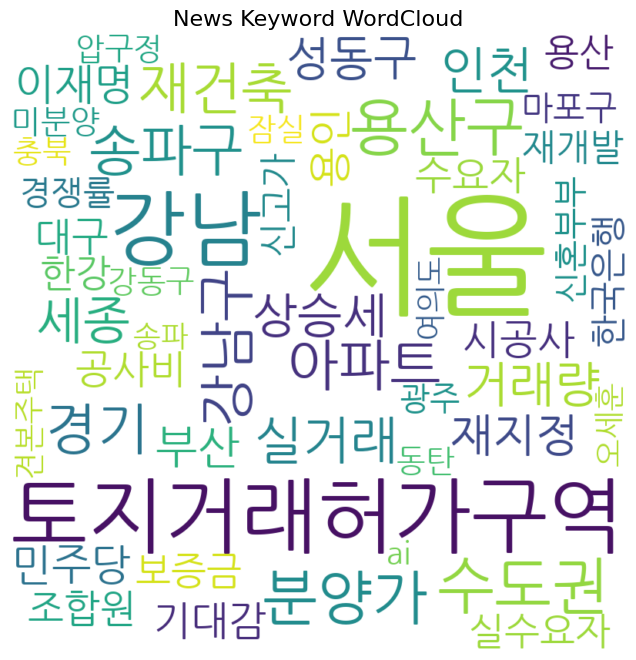

In [49]:
# 8️⃣ 워드클라우드 생성
wordcloud = WordCloud(
    font_path=font_path,  # 한글 폰트 경로 (한글 필수!)
    width=800,
    height=800,
    background_color='white',
    max_words=50,
    colormap='viridis'
).generate_from_frequencies(keyword_counter)

# 9️⃣ 시각화 출력
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('News Keyword WordCloud', fontsize=16)
plt.show()

In [ ]:
##### 5. Trend Search

# 전체 기간 키워드 빈도 계산
all_keywords = []

for lst in df_news['keyword_list']:
    for kw in lst:
        kw = kw.strip()
        if re.search(r'\d', kw):
            continue
        if kw in custom_stopwords:
            continue
        # 유사어 통합
        kw = replace_dict.get(kw, kw)
        all_keywords.append(kw)

# 가중치 반영한 전체 빈도 계산
total_counter = Counter()
for kw in all_keywords:
    weight = custom_weights.get(kw, 1.0)
    total_counter[kw] += weight

# 전체 기간 기준 상위 N개 키워드 선정
top_n = 100
top_keywords = [kw for kw, cnt in total_counter.most_common(top_n)]

# 월별 키워드 빈도 계산
keyword_summary = []

for month in df_news['year_month'].unique():
    month_df = df_news[df_news['year_month'] == month]

    month_keywords = []
    for lst in month_df['keyword_list']:
        for kw in lst:
            kw = kw.strip()
            if re.search(r'\d', kw):
                continue
            if kw in custom_stopwords:
                continue
            kw = replace_dict.get(kw, kw)
            month_keywords.append(kw)

    month_counter = Counter()
    for kw in month_keywords:
        weight = custom_weights.get(kw, 1.0)
        month_counter[kw] += weight

    # 상위 top_keywords 목록에 대해서만 빈도 기록
    for kw in top_keywords:
        cnt = month_counter.get(kw, 0)
        keyword_summary.append([month, kw, cnt])

# 데이터프레임 변환
df_keyword_summary = pd.DataFrame(keyword_summary, columns=['month', 'keyword', 'count'])

# pivot table 생성
keyword_pivot_table = df_keyword_summary.pivot(index='keyword', columns='month', values='count').fillna(0)

# 엑셀로 export
export_filename = 'news_analysis_export_top100.xlsx'
with pd.ExcelWriter(export_filename) as writer:
    news_volume_trend.to_excel(writer, sheet_name='News_Volume_Trend', index=False)
    keyword_pivot_table.to_excel(writer, sheet_name='Keyword_Pivot_Table')

print(f'✅ 엑셀파일 저장 완료 → {export_filename}')


✅ 엑셀파일 저장 완료 → news_analysis_export_top100.xlsx


In [ ]:
##### 6. Network Analysis

# 3️⃣ 단어쌍 (co-occurrence) 카운트
cooc_counter = Counter()

for lst in df_news['keyword_list']:
    # 전처리
    clean_lst = []
    for kw in lst:
        kw = kw.strip()
        if re.search(r'\d', kw):
            continue
        if kw in custom_stopwords:
            continue
        kw = replace_dict.get(kw, kw)
        clean_lst.append(kw)

    # 조합 만들기 (쌍)
    for kw1, kw2 in combinations(set(clean_lst), 2):
        weight1 = custom_weights.get(kw1, 1.0)
        weight2 = custom_weights.get(kw2, 1.0)
        pair_weight = weight1 * weight2  # 🚀 가중치 적용!
        cooc_counter[(kw1, kw2)] += pair_weight

In [ ]:
# 4️⃣ NetworkX 그래프 만들기
G = nx.Graph()

# top N쌍만 (예: top 50쌍)
for (kw1, kw2), cnt in cooc_counter.most_common(30):
    G.add_edge(kw1, kw2, weight=cnt)

# 5️⃣ pyvis 네트워크로 변환
net = Network(height='800px', width='100%', bgcolor='#ffffff', font_color='black')

# networkx → pyvis
net.from_nx(G)

for e in net.edges:
    # weight 에 따라 width scaling
    e['width'] = e['weight'] * 0.005   # 🚀 0.5 배수 → 원하는 만큼 조절 가능 (ex: 1.0 하면 더 굵어짐!)

# 6️⃣ 옵션 (원하면 자동 레이아웃도 가능)
net.repulsion(node_distance=200, central_gravity=0.3,
              spring_length=200, spring_strength=0.05,
              damping=0.95)

# 7️⃣ 저장 + 표시
net.show('cooccurrence_network.html')

In [ ]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from scipy.stats import t as t_statistic


In [ ]:
from statsmodels.stats.diagnostic import breaks_cusumolsresid
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS

In [ ]:
pwd

In [ ]:
# Upload the Excel file into a Pandas dataframe
df = pd.read_excel('raw.xlsx', sheet_name='Sheet2')
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
# Fit the quadratic trend model
df['time'] = np.arange(len(df))
df['time_sq'] = df['time'] ** 2
df['constant'] = 1

In [ ]:
print(df)

1. Index 시리즈 피팅
1.1 Index 시리즈가 2차항을 가지고 있는지 평가

In [ ]:
model = sm.OLS(df['Index'], df[['constant', 'time', 'time_sq']])
results = model.fit(cov_type='HAC', cov_kwds={'maxlags': 1})
print(results.summary())

# Extract the fitted series
df['fitted_values'] = results.fittedvalues

In [ ]:
# Apply the HP filter to the 'index' series without considering the quadratic trend
cycle, trend = sm.tsa.filters.hpfilter(df['Index'], lamb=1600)

# Add the HP-filtered trend back to the DataFrame
df['hp_trend'] = trend

In [ ]:
# Plot the original data, the quadratic trend, and the HP-filtered trend
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Index'], label='Original Data')
plt.plot(df['Date'], df['fitted_values'], label='Quadratic Trend', linestyle='--', color='r')
plt.plot(df['Date'], df['hp_trend'], label='HP Filtered Trend', linestyle='--', color='g')
plt.legend()

# Set the X-axis with the 'date' column
plt.xlabel('Date')
plt.ylabel('Index')
plt.title('Comparison of Quadratic Trend and HP Filtered Trend with Original Data')
plt.xticks(rotation=45)

# Display the plot
plt.show()

& Structural Change
2019M10

In [ ]:
& 번외: 기대인플레이션 Persistance

In [ ]:
### Define AR model to check a persistance

# Define the maximum number of lags you want to check
max_lags = 10

# Select the optimal number of lags using information criteria
result = ar_select_order(df['CPI_exp_1y'], max_lags, old_names=False, ic='aic', trend='ct')  ## aic, bic, hqic

# Obtain the selected lags based on information criteria
selected_lags = result.ar_lags

# Build the AR model with the selected lags
model = AutoReg(df['CPI_exp_1y'], lags=selected_lags, trend='ct')
ar_result = model.fit()

# Get the parameters of the AR model
params = ar_result.params

# Sum the coefficients of the AR terms
sum_of_coefficients = np.sum(params[1:])  # Exclude the intercept term

# Print the selected lags and the sum of coefficients
print(f"The selected lags based on information criteria: {selected_lags}")
print(f"The sum of coefficients of the selected AR terms is: {sum_of_coefficients}")

The selected lags based on information criteria: [1, 2, 3, 4]
The sum of coefficients of the selected AR terms is: 0.9638205197714442


In [ ]:
### Set the null hypothesis value
null_hypothesis_value = 1

# Calculate the standard error of the sum of coefficients
standard_error_sum = np.sqrt(np.sum(ar_result.bse[1:]**2))

# Calculate the t-statistic
t_stat = (sum_of_coefficients - null_hypothesis_value) / standard_error_sum

# Calculate the degrees of freedom
degrees_of_freedom = len(selected_lags)

# Calculate the p-value
p_value = 2 * t_statistic.cdf(-np.abs(t_stat), degrees_of_freedom)

# Print the t-statistic and the corresponding p-value
print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value}")

t-statistic: -0.21504817064576667
p-value: 0.840249154166426


In [ ]:
print(df)

                 Date  CPI   KRWUSD  KRWUSD_lag  KRWUSD_lag_mc    OIL  \
CPI_exp_1y                                                              
3.088965   2006-09-01  2.5   953.68      960.72          10.57  63.82   
3.076999   2006-10-01  2.2   954.23      953.68          -7.04  58.85   
3.087811   2006-11-01  2.1   936.22      954.23           0.55  59.13   
3.059719   2006-12-01  2.1   925.75      936.22         -18.01  62.00   
3.084474   2007-01-01  1.7   936.36      925.75         -10.47  54.24   
...               ...  ...      ...         ...            ...    ...   
3.113319   2023-04-01  3.7  1320.01     1305.73          34.99  79.44   
3.221883   2023-05-01  3.3  1328.21     1320.01          14.28  71.59   
3.474617   2023-06-01  2.7  1296.71     1328.21           8.20  70.23   
3.637580   2023-07-01  2.3  1286.30     1296.71         -31.50  76.39   
3.664992   2023-08-01  3.4  1318.47     1286.30         -10.41  81.40   

            OIL_lag  OIL_lag_mc  UNEMPLOYMENT  CPI

In [ ]:
# Check if the 'cpi_exp_1y' column is already in datetime format
df.set_index('CPI_exp_1y', inplace=True)

# Convert start and end dates to datetime format
start_date_subset = pd.to_datetime('2019-10-01')
end_date_subset = pd.to_datetime('2023-08-01')

# Divide the time series into subsets
subset = df.loc[(df.index >= start_date_subset) & (df.index <= end_date_subset)]

# Print the subset
print(subset)

KeyError: ignored

In [ ]:
### sub-set process

# Define the maximum number of lags you want to check
max_lags = 10

# Select the optimal number of lags using information criteria
result = ar_select_order(df['CPI_exp_1y'], max_lags, old_names=False, ic='aic', trend='ct')  ## aic, bic, hqic

# Obtain the selected lags based on information criteria
selected_lags = result.ar_lags

# Build the AR model with the selected lags
model = AutoReg(df['CPI_exp_1y'], lags=selected_lags, trend='ct')
ar_result = model.fit()

# Get the parameters of the AR model
params = ar_result.params

# Sum the coefficients of the AR terms
sum_of_coefficients = np.sum(params[1:])  # Exclude the intercept term

# Print the selected lags and the sum of coefficients
print(f"The selected lags based on information criteria: {selected_lags}")
print(f"The sum of coefficients of the selected AR terms is: {sum_of_coefficients}")

### Set the null hypothesis value
null_hypothesis_value = 1

# Calculate the standard error of the sum of coefficients
standard_error_sum = np.sqrt(np.sum(ar_result.bse[1:]**2))

# Calculate the t-statistic
t_stat = (sum_of_coefficients - null_hypothesis_value) / standard_error_sum

# Calculate the degrees of freedom
degrees_of_freedom = len(selected_lags)

# Calculate the p-value
p_value = 2 * t_statistic.cdf(-np.abs(t_stat), degrees_of_freedom)

# Print the t-statistic and the corresponding p-value
print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value}")

이전과 이후 구분

In [ ]:
# Print the first few rows of the dataframe
# print(df.head())  # five row display
df.columns  # column index
df.info()
# df.shape  # matrix size

In [ ]:
# SImple OLS

X = df[['mee','cha', 'mper']]

# Define a list of dependent variables
dependent_vars = ['absc_call', 'absc_cd', 'absc_b_3m', 'absc_b_1y', 'absc_b_3y', 'absc_b_5y', 'absc_b_10y']

# Create an empty list to store the results of each OLS regression
results = []

# Loop through the dependent variables and fit the OLS model with each variable
for var in dependent_vars:
    y = df[var]
    X = sm.add_constant(X)
    model =  sm.OLS(y, X).fit(cov_type='HC3')
    results.append(model)

    # Print the results of each OLS regression
    print(f"Model {len(results)}: {var} as dependent variable\n{model.summary()}")

# Plot the residual graph for the current model
    plt.plot(model.resid)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title(f"Residual plot for {var}")
    plt.xlabel("Observation")
    plt.ylabel("Residual")
    plt.show()

# 1. 종속변수와 독립변수간 선형관계 - 당연히 만족
# 2. 독립변수와 오차항간 상관관계가 없을 것 - 독립변수 설정 잘하면 문제 없음
# 3. 오차항의 기대값은 0 - 랜덤웍
# 4. 오차항은 정규분포 - 모집단 많으면 해결

# 5. 오차항의 분산이 모든 관찰치에서 일정한 상수일 것, 아닐 경우 이분산성(Heteroskedasticity) 발생
## 무조건부 이분산성은 독립변수 관찰값과 상관없는 이분산, 조건부(Conditional Variance) 이분산은 독립변수 관찰값과 상관있는 이분산, 조건부 이분산은 GARCH 사용
## Breusch-Pagan Test로 검정
## H0 = 이분산성 비존재, P value < 0.05시 기각가능해서 이분산 존재
## HAC (Newey-West Standard error, HAC Heteroskedasticity and Autocorrelation Consistent) standard errors로 수정가능, 이 경우 robust standard error

    # Breusch-Pagan test for heteroscedasticity
    bp_test = het_breuschpagan(model.resid, X)
    print(f"Breusch-Pagan test statistic: {bp_test[0]:.3f}")
    print(f"Breusch-Pagan p-value: {bp_test[1]:.3f}")
    if bp_test[1] < 0.05:
        print("Warning: The residuals exhibit heteroscedasticity.")

# 6. 오차항간 시차상관관계가 없을 것, 아닐 경우 계열상관성(Autoregression) 발생
## HAC (Newey-West Standard error, HAC Heteroskedasticity and Autocorrelation Consistent) standard errors로 수정가능, 이 경우 robust standard error
## Calculate Durbin-Watson statistic
## Durbin-Watson statistic for autocorrelation
    dw = durbin_watson(model.resid)
    print(f"Durbin-Watson statistic: {dw:.3f}")
## check for autocorrelation

    if dw < 1.5 or dw > 2.5:
        print("Warning: The residuals exhibit autocorrelation.")


 # Jarque-Bera test for normality of residuals
    jb_test = jarque_bera(model.resid)
    test_statistic = jb_test[0]
    p_value = jb_test[1]
    if p_value < 0.05:
        print("Warning: The residuals are not normally distributed (p-value = {:.4f})".format(p_value))
    else:
        print("The residuals are normally distributed (p-value = {:.4f})".format(p_value))

    # ADF test for stationarity of residuals
    residuals = model.resid
    adf_test = sm.tsa.stattools.adfuller(residuals)
    test_statistic = adf_test[0]
    p_value = adf_test[1]
    if p_value < 0.05:
        print("Warning: The residuals have a unit root (p-value = {:.4f})".format(p_value))
    else:
        print("The residuals do not have a unit root (p-value = {:.4f})".format(p_value))

In [ ]:
# 7. 독립변수간 상관관계가 없을 것, 아닐 경우 다중공선성(Multicollinearity) 발생
## calculate the VIF for each independent variable
vif = pd.DataFrame()
independent_vars=['mee2','cha','mper']   # only pass the column names
vif["variables"] = independent_vars
vif["VIF"] = [variance_inflation_factor(df[independent_vars].values, i) for i in range(len(independent_vars))]

### check for high VIFs (typically a VIF greater than 5 or 10 is considered high)
high_vif = vif[vif['VIF'] > 5]

# print the variables with high VIFs
if len(high_vif) > 0:
    print("Warning: The following variables have high VIFs:")
    print(high_vif)

    # if there are high VIFs, drop one of the variables with the highest VIF
    var_to_drop = high_vif.sort_values('VIF', ascending=False)['variables'].iloc[0]
    df.drop(var_to_drop, axis=1, inplace=True)
    independent_vars.remove(var_to_drop)
else:
    print("No variable has a high VIF.")

In [ ]:
# 금융데이터처럼 변동성이 시간에 따라 변화(clustering) = 시계열 데이터의 조건부 분산이 과거 시점의 오차항과 자기상관
# 시변하는 조건부 분산을 GARCH로 예측
## 실제 value와 fit value로 arch가 잘 맞는지 보고
## redisual이 정규분포하는지 보고
## conditional variance가 시변하는지 봄
### 이후 conditional variance그래프를 그리고 주요 뉴스 전후로 어떻게 바뀌는지 확인

# 참고
## AR(1)은 t기의 오차항이 t-1기의 오차항과 관련
## ARCH는 t기의 오차항의 분산이 t-1기의 오차항 분산과 관련
### 오차항의 분산이 전기 오차항의 제곱에 관련 있는 경우를 autoregressive conditional heteroscedasticity(ARCH)
### 오차항의 분산이 여러 기의 오차항 제곱과 관련 있는 경우 generalized ARCH(GARCH)
### 금융모형 다수 등장

In GARCH (Generalized Autoregressive Conditional Heteroscedasticity) models, the parameters (p,q) represent the orders of the autoregressive and moving average terms, respectively, that are used to model the conditional variance of a time series.

The "p" parameter specifies the order of the autoregressive term, which models the dependence of the current variance on the past variances. The "q" parameter specifies the order of the moving average term, which models the dependence of the current variance on the past squared error terms.

Together, the (p,q) parameters determine the complexity of the GARCH model and how well it can capture the volatility patterns in the data. In practice, these parameters are usually chosen through a process of model selection, such as using information criteria like the Akaike Information Criterion (AIC) or the Bayesian Information Criterion (BIC), or through cross-validation techniques.

delta(y_t) = beta_0 + beta_1*y_(t-1)(=AR1)+e_t(=error term) ~ e_t=beta_2(square(hat^2_t))   ~ N(0, hat_t)
hat^2_t = Omega + sigma(alpha*h_(t-p)(=AR term, p)) + (Beta*e_(t-q))(MA term, q)

AR(1) 과정에서 오차항의 분산이 이분산성(시변성), 클러스터링 분산을 보일 경우
오차항의 시변하는 분산 hat^2을 ARIMA 과정을 통해 별도로 추정
이 때 Omega는 시변성이 없었을 경우 나타날 Constant mean, alpha는 AR Term의 계수
Beta는 MA Term의 계수로 과거 에러텀 제곱의 영향

In [ ]:
# Define ranges of p and q to search over
p_range = range(1, 3)
q_range = range(1, 3)

# Initialize the best model and criterion values
best_aic = np.inf
best_bic = np.inf
best_p = 0
best_q = 0

# Loop through all combinations of p and q values
for p in p_range:
    for q in q_range:
        # Fit a GARCH model for each combination of p and q
        model = arch_model(df['b_3y_l'], vol='GARCH', p=p, q=q, mean='constant', dist='Normal')
        result = model.fit(disp='off')

        # Calculate the AIC and BIC for each model
        aic = result.aic
        bic = result.bic

        # Check if the current model has a lower AIC or BIC than the previous best model
        if aic < best_aic:
            best_aic = aic
            best_p = p
            best_q = q

        if bic < best_bic:
            best_bic = bic
            best_p = p
            best_q = q

# Print the optimal (p, q) values and criterion values
print("Optimal (p, q) values based on AIC: ({}, {})".format(best_p, best_q))
print("AIC value for optimal model: {}".format(best_aic))

print("Optimal (p, q) values based on BIC: ({}, {})".format(best_p, best_q))
print("BIC value for optimal model: {}".format(best_bic))

In [ ]:
# Fit the GARCH(p,q) model

# Define the independent variables
y = df['b_3y_l']

# Fit the GARCH(1,1) model
am = arch_model(y, mean="AR", vol="GARCH", p=1, q=1, dist='Normal')     ## Clear Trend가 있을 경우 mean = AR, 아닐 경우 Conditional mean이 Constant하다고 하는 것이 보통
results = am.fit()

# Print model summary
print(results.summary())

## log-likelihood value = -6476.46 = fit well
## coefficients of vol is fit well
### omega coefficient = the constant component of the variance = 0.0253 > i.e., long-run average의 존재
### alpha1 = conditional variance lagged one period > 0.1 > short past squard residuals affect currentvolitaility, AR(1) term
### beta1 = conditional variance itself > 0.8000 > long past squared residuals affect current volitaility, MA(1) term
## beta1 < 1 and alpha+beta < 1 (1,1)
## i.e., the tendency for periods of high volatility to follow periods of high volatility and for periods of low volatility to follow periods of low volatility.

In [ ]:
# Plotting the actual and predicted values of the dependent variable:
## means how well the model fits the actual data. closely = fit
predicted = results.conditional_volatility
actual = np.sqrt(results.resid**2)

plt.plot(actual, label='Actual')
plt.plot(predicted, label='Predicted')
plt.legend()
plt.show()

# Plotting the standardized residuals:
## standardized residuals, normally distributed around zero = fit

from statsmodels.graphics.tsaplots import plot_acf

std_resid = results.resid / results.conditional_volatility
# (obs - actu / con var) = like z-score.
# rule of thumb = between +-2 = ok

plt.plot(std_resid)
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

# Plotting the volatility of the dependent variable:
## volatility of the dependent variable changes over time.
## the volatility is constant = not fit
plt.plot(results.conditional_volatility)
plt.show()

In [ ]:
import seaborn as sns


# conditional_volatility = results.conditional_volatility
# fx = sns.boxplot(x='cha_change', y=conditional_volatility, data=df, palette='Set2',showfliers=False)
# plt.ylim([0, 0.1])
# fx.set_xlabel("Policy Rate Change")
# fx.set_ylabel("Conditional Variance")

fig, fx = plt.subplots(figsize=(2.5, 4))

# df_filtered = df[df["mper_change"] != "all range"]
# fx = sns.boxplot(x='mper_change', y=conditional_volatility, data=df_filtered, palette='Set2',showfliers=False)
# plt.ylim([0, 0.1])
# fx.set_xlabel("MPR Publication")
# fx.set_ylabel("")
# fx.set(yticklabels=[])

# df_filtered = df[df["mee2_change"] != "all range"]
# fx = sns.boxplot(x='mee2_change', y=conditional_volatility, data=df_filtered, palette='Set2', showfliers=False)
# plt.ylim([0, 0.1])
# fx.set_xlabel("Minutes w/o rate change")
# fx.set_ylabel("")
# fx.set(yticklabels=[])


df_filtered = df[df["spe_change"] != "all range"]
fx = sns.boxplot(x='spe_change', y=conditional_volatility, data=df_filtered, palette='Set2', showfliers=False)
plt.ylim([0, 0.1])
fx.set_xlabel("Governer's Speech")
fx.set_ylabel("")
fx.set(yticklabels=[])


In [ ]:
# Perform tests for heteroskedasticity and autocorrelation
lb_test = acorr_lm(results.resid)     # for autocorrelation
arch_test = het_arch(results.resid)   # for heteroscedasticity


# Check for heteroskedasticity and print a warning if detected
print("ARCH-LM test statistic:", arch_test[0])
print("ARCH-LM test p-value:", arch_test[1])

if arch_test[1] < 0.05:
    print("\nWarning: Heteroskedasticity detected according to the ARCH-LM test.")

# Check for autocorrelation and print a warning if detected

print("Lagrange Multiplier test statistic:", lb_test[0])
print("Lagrange Multiplier test p-value:", lb_test[1])

if lb_test[1] < 0.05:
    print("\nWarning: Autocorrelation detected according to the Lagrange Multiplier test.")

# Check if the model is ARCH-effective using the p-value of the LM test
if lb_test[1] < 0.05:
    print("\nThe model is not ARCH-effective according to the LM test.")
else:
    print("\nThe model is ARCH-effective according to the LM test.")

In [ ]:
# Assuming your fitted GARCH model is stored in the variable 'results'
# forecast_volatility = results.forecast(horizon=1)
# conditional_volatility = np.sqrt(forecast_volatility.variance.iloc[-len(df):])


# Get the conditional volatility values
conditionalvolatility = pd.Series(results.conditional_volatility, index=df.index)
actualvolatility = np.sqrt(results.resid**2)

# Export the data to an Excel file
conditionalvolatility.to_excel('conditional_volatility.xlsx', header=['Conditional Volatility'])
actualvolatility.to_excel('acualvolatility.xlsx', header=['Actual Volatility'])

The main difference between EGARCH (Exponential GARCH) and GARCH (Generalized Autoregressive Conditional Heteroscedasticity) models is the way they model the conditional volatility of a time series.

GARCH models assume that the conditional volatility is a function of past squared error terms and past conditional variances. EGARCH models, on the other hand, allow the conditional variance to depend on both past squared error terms and past absolute error terms. This means that EGARCH models can capture the asymmetric effects of positive and negative shocks on volatility.

In other words, the EGARCH model allows for the possibility that an unexpected shock that leads to a large negative return has a different impact on volatility than an unexpected shock that leads to a large positive return. This is important in financial applications, where volatility tends to increase more after large negative returns (i.e., "leverage effect").

Overall, the EGARCH model is a more flexible model that can capture the asymmetric effects of shocks on volatility, while the GARCH model is a more simple model that assumes symmetric effects.

In [ ]:
# # Fit the EGARCH(p,q) model

# # Define the independent variables
# y = df['b_3y_l']

# # Fit the EGARCH(1,1) model
# am = arch_model(y, mean="AR", vol="EGARCH", p=1, q=1, dist='Normal')     ## Clear Trend가 있을 경우 mean = AR, 아닐 경우 Conditional mean이 Constant하다고 하는 것이 보통
# results = am.fit()

# # Print model summary
# print(results.summary())